**7장 – 앙상블 학습과 랜덤 포레스트**

_이 노트북은 7장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 투표기반 분류기
* 정확도가 80%인 여러 분류기 훈련 -> 예측을 모아 가장 많이 선택된 클래스 예측
  - 직접 투표 hard voting 분류기, 가장 뛰어난 개별 분류기보다 정확도가 높을 확률이 큼
* 랜덤 추측보다 조금 더 높은 성능의 약한 학습기 weak learner 일지라도 충분히 많고 다양하면 동전 앞 51%, 뒤 49% -> 1000번 시행, 약 앞 510, 뒤 490 : 앞면 다수
  - 1000번 던진 후 앞면이 다수가 될 확률이 약 75%, 10,000번 던지면 97% 이상
  - 큰 수의 법칙 law of large numbers

In [ ]:
from scipy.stats import binom
1-binom.cdf(499, 1000, 0.51)
1-binom.cdf(4999, 10000, 0.51) # 0.978

0.9777976478701103

* 51%의 정확도를 가진 1,000개의 분류기로 앙상블 모델 구축 -> 투표 기반 분류기 75% 정확도
  - 가정: 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없을 때 성립 iid 
    - 같은 데이터로 훈련하기 때문에 이런 가정이 맞지 않음.
    - 같은 종류의 오차를 만들기 쉬워 잘못된 클래스 다수, 앙상블 정확도 낮아짐
* 독립적인 다양한 분류기를 얻는 방법은 각기 다른 알고리즘으로 학습시킴, 매우 다른 종류의 오차, 앙상블 정확도 향상

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_moons
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import PolynomialFeatures

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.25)
X_train, X_test, y_train, y_test = X[:800], X[800:], y[:800], y[800:]

In [ ]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

In [ ]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

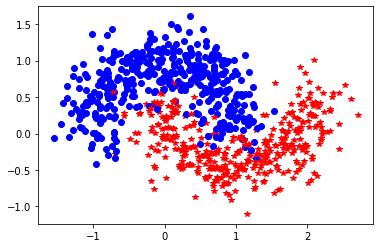

In [ ]:
import matplotlib.pyplot as plt

for j in range(len(X_train)):
  if y_train[j] == 1:
    plt.plot(X_train[j,0], X_train[j,1], "r*")
  else:
    plt.plot(X_train[j,0], X_train[j,1], "bo")

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.855
RandomForestClassifier 0.96
SVC 0.95
VotingClassifier 0.945


> 거의 매번 SVC가 좋음...

* Random Forest 자체에서도 voting이 있음

* 모든 분류기가 predict_proba() 메서드가 있어서 클래스 확률을 예측할 수 있으면
  - 개별 분류기의 예측확률을 평균내어 확률이 가장 높은 클래스 예측 -> 간접 튜표 soft voting
  - 확률이 가장 높은 투표에 비중을 두므로 직접 투표보다 성능이 높음 voting="hard" -> voting="soft"
* SVC 기본값에는 확률 저장하지 않음. probability=True
  - 확률 추정을 위해 교차검증을 하므로 속도는 느려지지만, predict_proba() 메서드 사용 가능

# 배깅과 페이스팅
* 각기 다른 훈련 알고리즘
* 같은 알고리즘을 사용하고 훈련세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습
* 배깅 bagging: bootstrap aggregating: 훈련셋에서 중복을 허용하여 샘플링
  - 부트스트래핑 bootstrapping: 중복을 허용한 리샘플링
* 페이스팅 pasting: 중복을 허용하지 않고 샘플링
* 수집 함수: 분류일 때는 통계적 최빈값 statistical mode, 회귀에서는 평균을 계산
* 개별 예측기는 원본 훈련세트보다 훨씬 크게 편향될 수 있지만, 수집함수를 통과하면 편향, 분산 감소
* 일반적으로 앙상블 결과는 원본 데이터셋으로 하나의 예측기를 통과시킬 때와 비교해 편향은 비슷, 분산 감소
* 모든 예측기 병렬 학습 가능, 예측도 향상 가능 -> 배깅과 페이스팅의 확장성

## 사이킷런의 배깅과 페이스팅
* 간편한 API: BaggingClassifier(회귀의 경우 BaggingRegressor)
* 결정트리 분류기 500개 앙상블 훈련, max_samples: 0.0~1.0 사이의 실수, 샘플링 수 = 훈련세트 * max_samples
* 페이스팅: bootstrap = False
* n_jobs: 훈련과 예측에 사용할 코어 수 : -1: 가능한 모든 코어 사용, 기본값=1

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
# predict_proba() 메서드가 있으면 간접투표 사용

0.94


* 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음
* 하지만 다양성을 추가하면 예측기의 상관관계를 줄이므로 앙상블의 분산을 감소,
* 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호
* 시간과 CPU 파워에 여유가 있으면 교차검증으로 배깅과 페이스팅 모두 평가해서 나은 쪽 선택

## oob 평가

* 배깅을 사용하면 어떤 샘플은 여러번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있음
* BaggingClassifier는 기본값으로 중복을 허용하기 때문에 bootstrap=True 훈련 세트 크기만큼인 m개.....
* 선택되지 않을 확률 1-1/m, m번 반복 (1-1/m)^m ---> e^(-1), 샘플링될 확률 = 63.21%
* 선택되지 않은 훈련샘플의 나머지 (37%) : oob(out-of-bag) 샘플
* 예측기가 훈련되는 동안 oob샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가
* 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻음
* oob_score =True : 훈련이 끝난 후 자동으로 oob 평가 수행
* 평가 점수 결과는 oob_score_ 변수에 저장

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.93875

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.94

In [ ]:
bag_clf.oob_decision_function_

array([[0.32222222, 0.67777778],
       [0.06024096, 0.93975904],
       [0.97156398, 0.02843602],
       ...,
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

# 랜덤패치와 랜덤서브스페이스
* BaggingClassifier는 특성 샘플링도 지원, max_features, bootstrap_features
* 작동방식은 max_samples, bootstrap과 동일하지만 샘플이 아니고 특성에 대한 샘플링
* 무작위로 선택한 입력 특성의 일부분으로 훈련
* 이미지와 같은 매우 고차원의 데이터셋을 다룰 때 유용
* 훈련 특성과 샘플을 모두 샘플링하는 것을 랜덤패치 방식(Random patches method)
* 훈련 샘플을 모두 사용하고 (bootstrap=False, max_samples=1.0), 특성은 샘플링(bootstrap_features=True, max_features<1) => 랜덤서브스페이스방식
* 특성 샘플링 => 다양한 예측기, 편향을 늘리는 대신 분산을 낮춤

# 랜덤 포레스트
* 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정트리의 앙상블
* max_samples 훈련샘플 크기, 기본값 1.0
* BaggingClassifier에 DecisionTreeClassifier를 넣어 만들 수 있음, 결정트리 이외의 모델 앙상블할때도 유용
* RandomForestClassifier 결정트리에 최적화되어 사용하기 편리
* RandomForestRegressor 회귀

In [ ]:
# 16개 리프노드를 갖는 500개 트리로 이루어진 랜덤포레스트 분류기, n_jobs=-1 : 시스템에 있는 모든 CPU 코어 사용
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test,y_pred_rf)

0.955

* RandomForestClassifier : DecisonTreeClassifier와 BaggingClassifier의 매개변수를 모두 가지고 있음.
* 예외 항목: splitter="best", presort="False", max_samples=1.0, base_estimator="DecisionTreeClassifier"
              DecisionTreeClassifier      /    BaggingClassfier
* 트리의 노드를 분할할때 전체특성 중 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 무작위성을 더 주입
* 트리를 더 다양하게 만들고, 편향을 손해보는 대신 분산을 낮추어, 전체적으로 훌륭한 모델을 만듬


In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt",max_leaf_nodes=16), n_estimators=500) # RandomForestClassifier와 비슷하게 만듬
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred_bag)

0.95

## 엑스트라 트리
* 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용
* 트리를 더욱 무작위로 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할 선택
* 익스트림 랜덤 트리 앙상블/ 엑스트라 트리 : 극단적으로 무작위한 트리의 랜덤 포레스트 => 편향은 늘지만 분산은 줄어듬, 일반적 랜덤포레스트보다 빠름
* ExtraTreeClassifier/ ExtraTreeRegressor
* RF 보다 더 나을지 나쁠지 예단하기 어렵고, 둘 다 시도해보고 교차검증으로 비교 시도, 그리드 탐색으로 하이퍼파라미터 튜닝


## 특성 중요도
* 장점 : 특성의 상대적 중요도를 측정하기 쉬움
* DecisionTreeClassifier : 일부 특성 배제, RandomForestClassifier : 모든 특성 평가
* 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소하는 지 확인하여 특성의 중요도 측정, 가중치 평균, 가중치는 연관된 샘플 수
* 특성 중요도 : (현재노드 샘플비율*불순도) -(왼쪽자식노드 샘플비율*불순도)-(오른쪽자식노드 샘플비율*불순도), 특성중요도 합이 1이 되도록 정규화
* 랜덤포레스트 특성중요도 : 각결정트리 특성 중요도를 더한 후 트리수로 나눈 것

In [ ]:
# iris 데이터셋 : 꽃잎길이와 너비는 중요하고 꽃받침 길이와 너비는 덜 중요해 보임
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name,score)

sepal length (cm) 0.09516181964942332
sepal width (cm) 0.024133186861319343
petal length (cm) 0.4495821278707204
petal width (cm) 0.43112286561853697


pixel1 0.0
pixel2 0.0
pixel3 0.0
pixel4 0.0
pixel5 0.0
pixel6 0.0
pixel7 0.0
pixel8 0.0
pixel9 0.0
pixel10 0.0
pixel11 0.0
pixel12 0.0
pixel13 1.1815858500539358e-07
pixel14 5.111272290394936e-08
pixel15 0.0
pixel16 0.0
pixel17 0.0
pixel18 0.0
pixel19 0.0
pixel20 0.0
pixel21 0.0
pixel22 0.0
pixel23 0.0
pixel24 0.0
pixel25 0.0
pixel26 0.0
pixel27 0.0
pixel28 0.0
pixel29 0.0
pixel30 0.0
pixel31 0.0
pixel32 0.0
pixel33 0.0
pixel34 6.213515501499563e-08
pixel35 1.0625038756609855e-06
pixel36 7.13745762217438e-07
pixel37 2.1498952630521855e-06
pixel38 2.038955518734568e-06
pixel39 1.7409615456794632e-06
pixel40 3.4738027157412045e-06
pixel41 3.1164467538818193e-06
pixel42 2.9076919731669393e-06
pixel43 3.853611839813169e-06
pixel44 3.4931942228039358e-06
pixel45 4.162999651916451e-06
pixel46 2.5575081251051585e-06
pixel47 5.926540263881678e-07
pixel48 4.627079094512358e-07
pixel49 7.336467132420659e-07
pixel50 1.4431497707046775e-06
pixel51 5.545906557933651e-07
pixel52 4.6594616035311957e-

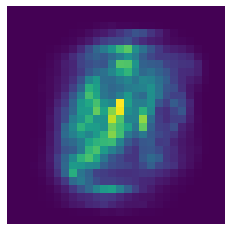

In [ ]:
# MNIST 데이터셋
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784',version=1, as_frame=False)
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(mnist["data"], mnist["target"])
for name, score in zip(mnist["feature_names"], rnd_clf.feature_importances_):
    print(name,score)
a = rnd_clf.feature_importances_
b = a.reshape(28,28)
plt.imshow(b)
plt.axis('off')
plt.show()

# 부스팅 boosting/hypothesis boosting
* 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
* 앞의 모델을 보완해 나가면서 일련의 예측기를 학습
* 에이다부스트 AdaBoost/Adaptive Boosting & 그래디언트부스팅 Gradient Boosting

## 에이다부스트 AdaBoost
* 이전 모델이 과소적합했던 훈련샘플의 가중치를 더 높임,
* 새로운 예측기는 학습하기 어려운 샘플에 맞춰짐
* 첫 번재 분류기(예를 들어, 결정트리)를 훈련시키고 예측
* => 잘못 분류된 훈련샘플의 가중치를 상대적으로 높임,
* 두 번째 분류기는 업데이트된 가중치를 사용해 훈련하고 다시 예측
* => 다시 가중치 업데이트
* 그림7-8 : 규제를 강하게 한 RBF 커널 SVM 분류기, 경사하강법과 비슷
*    SVC 모델에서 fit 메서드를 호출할 때, sample_weight 매개변수를 사용해 훈련샘플의 
*      가중치 부여. 왼쪽 가중치 2배, 오른쪽 1.5배
*    경사하강법은 비용함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정
*   에이다부스트는 점차 더 좋아지도록 앙상블에 예측기 추가
*  모든 예측기가 훈련을 마치면 이 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 만듬
*  가중치가 적용된 훈련세트의 전반적 정확도에 따라 예측기마다 다른 가중치 적용
*  단점: 이전예측기가 훈련되고 평가한 뒤에 학습하므로 병렬화 혹은 분할할 수 없다. 
*        배깅이나 페이스팅만큼 확장성 없음

*  w^(i): 샘플 가중치, 1/m으로 초기화
*  첫번째 예측기 학습 후 가중치 적용된 에러율 r1 계산, j번째 예측기에 대해
*   에러율 r_j = sum_{i번째 샘플에 대해 j번째 예측이 틀린경우} w^(i) / sum_{i=1}^m w^(i)
*  예측기 가중치 alpha_j = eta log((1-r_j)/r_j), eta 기본값 1, 
*   예측기가 정확할수록 가중치 올라감, 무작위 예측 가중치 0, 무작위 보다 나쁘면 음수
*  샘플 가중치 업데이트, 잘못 분류된 샘플 가중치 증가
*  w^(i) = w^(i) 맞았을때, w^(i) = exp(alpha_j) 틀렸을 때  => 모든 샘플의 가중치 정규화
* 새 예측기가 업데이트된 가중치 사용 훈련하고 전체 과정 반복
* 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지
* 예측 : 모든 예측기의 예측 계산, 예측기 가중치 alpha_j 를 더해 예측 결과 만듬, 
*       가중치 합이 가장 큰 클래스가 예측 결과
*        y^hat(x) = argmax_k sum_{y^hat(x)=k} alpha_j
* SAMME : 에이다부스트의 다중 클래스 버전, 
*    Storage Additive Modeling using a Multiclass Exponential loss function
*    클래스가 두 개 뿐일때 에이다부스트와 동일, alpha_j = eta(log((1-r_j)/r_j)+log(K-1))
* 예측기가 클래스의 확률을 추정할 수 있으면,(predict_proba()가 있다면 ), 
*    SAMME.R 이라는 SAMME의 변종 사용 (R:real)=>클래스 확률에 기반하여 성능좋음
* AdaBoostClassifier 알고리즘 기본값 SAMME.R, 'SAMME'로 변경 가능 '28번 참조'
* 200개의 아주 작은 결정트리를 기반으로 에이다부스트 훈련, max_depth=1, 
*   결정노드 하나와 리프노드 2개, AdaBoostClassifier 기본추정기
* AdaBoostRegressor 기본추정기는 깊이 3인 DecisionTreeRegressor

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train,y_train)
y_pred_ada = ada_clf.predict(X_test)
accuracy_score(y_test,y_pred_ada)
# 에이다 부스트 앙상블이 훈련세트에 과대적합되면 추정기 수를 줄이거나 추정기의 규제을 더 강하게

0.95

## 그레디언트 부스팅
* 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가
* 샘플 가중치 수정(에이다부스팅)대신 이전 예측기가 만든 잔여오차(Residual error)에 새로운 예측기를 학습
* 결정 트리를 기반 예측기를 사용하는 회귀 문제: 그레디언트 트리 부스팅, 그레디언트 부스티드 회귀 트리 GBRT

In [ ]:
# 잡음섞인 2차곡선 형태 훈련세트에 DecisionTrerRegressor 학습
import numpy as np
X = np.random.rand(100,1) - 0.5
Xlist = list(X); Xlist.sort(); X = np.array(Xlist)
y = 3*X**2 + 0.1*np.random.randn(100,1)

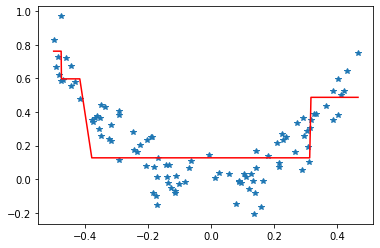

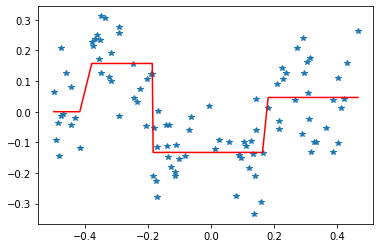

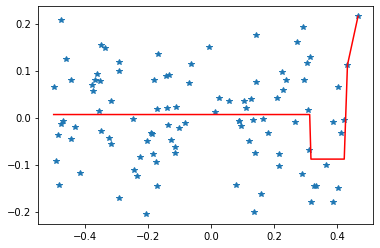

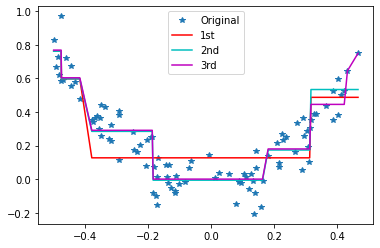

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2) 
tree_reg1.fit(X,y)
y1 = tree_reg1.predict(X); y1=y1.reshape(100,1)

y2 = y - y1
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)
haty2 = tree_reg2.predict(X); haty2 = haty2.reshape(100,1)

y3 = y2 - haty2
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3); 
haty3 = tree_reg3.predict(X); haty3 = haty3.reshape(100,1)

y_pred = sum(tree.predict(X) for tree in (tree_reg1, tree_reg2, tree_reg3))

plt.figure()
plt.plot(X,y,'*',X,y1,'r-')
plt.show()

plt.figure()
plt.plot(X,y2,'*',X,haty2,'r-')
plt.show()

plt.figure()
plt.plot(X,y3,'*',X,haty3,'r-')
plt.show()

plt.figure()
plt.plot(X,y,'*',X,y1,'r-', X,y1+haty2,'c-', X,y1+haty2+haty3,'m-')
plt.legend(['Original','1st','2nd','3rd'])
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


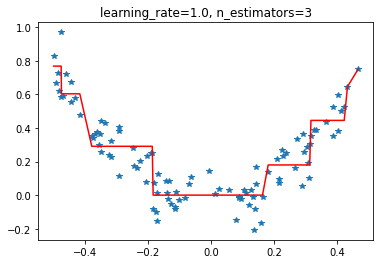

In [ ]:
# GBRT GradientBoostRegressor, 
# n_estimators : 트리 수, max_depth, 
#   min_samples_leaf (RandomForestRegressor): 결정트리 성장 제어
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)
haty = gbrt.predict(X)
plt.figure()
plt.plot(X,y,'*',X,haty,'r-')
plt.title('learning_rate=1.0, n_estimators=3')
plt.show()
#트리가 충분하지 않음

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


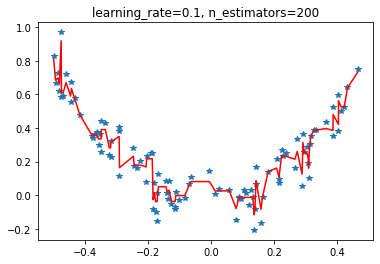

In [ ]:
#ravel()
#learning_rate=0.1, 축소Shrinkage라 부르는 규제방법
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1)
gbrt.fit(X,y)
haty = gbrt.predict(X)
plt.figure()
plt.plot(X,y,'*',X,haty,'r-')
plt.title('learning_rate=0.1, n_estimators=200')
plt.show()
#트리가 너무 많아 과대적합, 최적의 트리를 찾기위해서는 조기종료기법(4장)
# staged_predict() 메서드 : 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 
#  순회하는 반복자를 반환

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


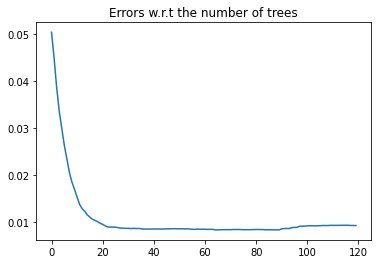

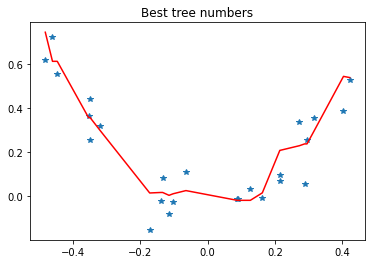

In [ ]:
# 120개의 트리로 GBRT 앙상블을 훈련시키고 최적의 트리를 찾기 위해 
# 각 훈련단계에서 검증오차 측정
# 마지막에 최적의 트리수를 사용해 새로운 GBRT 앙상블 훈련
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)
Xlist = list(X_val); Xlist.sort(); Xval = np.array(Xlist)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val,y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train,y_train)

yval = gbrt_best.predict(Xval)

plt.figure()
plt.plot(errors)
plt.title('Errors w.r.t the number of trees')
plt.show()

plt.figure()
plt.plot(X_val,y_val,'*',Xval,yval,'r-')
plt.title('Best tree numbers')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

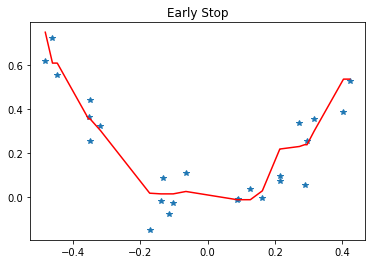

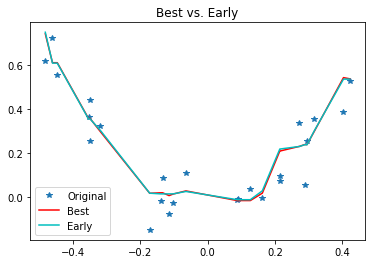

In [ ]:
bst_n_estimators #85 최적트리개수
# 많은 수의 트리를 먼저 훈련시키고 최적의 수를 찾기위해 살펴보는 대신 실제로 훈련을 
# 중지하는 방법으로 조기종료 구현
# warm_start = True 로 설정하면 fit() 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해줌
# 연속해서 다섯 번 반복동안 검증오차가 향상되지 않으면 훈련을 멈춤
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train,y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

gbrt.n_estimators # 60

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=gbrt.n_estimators)
gbrt_best.fit(X_train,y_train)

yval2 = gbrt_best.predict(Xval)

plt.figure()
plt.plot(X_val,y_val,'*',Xval,yval2,'r-')
plt.title('Early Stop')
plt.show()

plt.figure()
plt.plot(X_val,y_val,'*',Xval,yval,'r-',Xval,yval2,'c-')
plt.title('Best vs. Early')
plt.legend(['Original','Best','Early'])
plt.show()


* 그래디언트부스팅에 조기종료 기능, validation_fraction 비율(기본값 0.1)만큼 떼내어 측정한 손실이 n_iter_no_change 반복동안 tol 값(기본값 1.e-4)이상 향상되지 않으면 훈련이 멈춤
* 각 트리가 훈련할 때 사용할 훈련샘플의 비율 지정 : subsample 매개변수
* subsample = 0.25, 무작위로 선택된 25%의 훈련샘플로 학습, 편향이 높아지는 대신 분산이 낮아짐, 훈련속도가 높아짐
* 확률적 그래디언트 부스팅 Stochastic Gradient Boosting
* 비용함수 loss : 기본값 'deviance' (로지스틱 손실 함수), 'exponential'(에이다부스트에서 사용), 'ls'(최소제곱, GradientBoostingRegressor에서 사용), 'lad' 최소 절대값 오차, 'huber' 후버손실함수, 'quantile' 사분위 손실함수
* XGBoost : 최적화된 그래디언트 부스팅 구현 / eXtreme Gradient Boosting
*     DMLC (Distributed deep Machine Learning Community) 일원인 텐지 쳰 Tianqi Chen 이 개발
*   목표는 매우 빠른 속도, 확장성, 이식성
*    머신 러닝 경연대회 우승후보의 주요 도구

[03:48:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:48:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.342575
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.312725
[2]	validation_0-rmse:0.287957
[3]	validation_0-rmse:0.264339
[4]	validation_0-rmse:0.243323
[5]	validation_0-rmse:0.225338
[6]	validation_0-rmse:0.208536
[7]	validation_0-rmse:0.193672
[8]	validation_0-rmse:0.180516
[9]	validation_0-rmse:0.167428
[10]	validation_0-rmse:0.157014
[11]	validation_0-rmse:0.14815
[12]	validation_0-rmse:0.140246
[13]	validation_0-rmse:0.133241
[14]	validation_0-rmse:0.127208
[15]	validation_0-rmse:0.121737
[16]	validation_0-rmse:0.117435
[17]	validation_0-rmse:0.114023
[18]	validation_0-rmse:0.111207
[19]	validation_0-rmse:0.108522
[20]	validation_0-rmse:0.106424
[21]	validation_0-rms

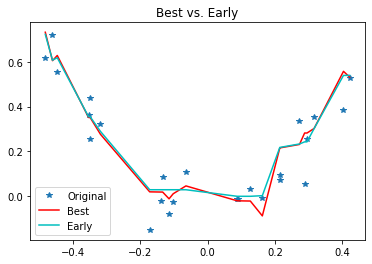

In [ ]:
# LightGBM : 히스토그램 기반 그레디언트 부스팅 => HistGradientBoostingClassifier, ~Regressor
import xgboost # conda install -c conda-forge py-xgboost-cpu
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train,y_train)
y_pred = xgb_reg.predict(Xval)

xgb_reg.fit(X_train,y_train, 
            eval_set=[(X_val,y_val)], early_stopping_rounds=2)
y_pred2 = xgb_reg.predict(Xval)

plt.figure()
plt.plot(X_val,y_val,'*',Xval,y_pred,'r-',Xval,y_pred2,'c-')
plt.title('Best vs. Early')
plt.legend(['Original','Best','Early'])
plt.show()

# 스태킹 Stacking, stacked generalization
* 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수(직접투표같은)를 사용하는 대신 취합하는 모델을 훈련
* 그림 7-12, 서로다른 예측기(3.1,2.7,2.9) => 마지막 예측기, 블렌더 Blender, 메타학습기 Meta learner
* 블렌더 학습시키는 방법 : 홀드 아웃 Hold-out 세트를 사용
* cf) 아웃오브폴드 예측(Out-of-fold): 스태킹, 홀드 아웃: 블렌딩 
*     아웃오브폴드 예측은 k-겹 교차검증에서 검증 폴드의 결과를 모두 모은 것, cross_val_predict() 함수 사용
* 홀드 아웃 세트 사용 블렌딩 : 훈련세트를 두개의 서브셋으로 나눔 => 첫번째 서브셋은 첫번째 레이어의 예측 훈련 
*    => 첫번째 레이어 예측기로 두번째 홀드아웃 세트에 대한 예측 => 훈련동안 서로 보지 못했으므로 완전히 새로운 예측 
*    => 홀드아웃세트에 대한 세개의 예측 => 타깃값 + 예측값 을 입력특성으로 사용하는 새로운 훈련세트, 3차원, 
*    => 블렌더가 새로운 훈련세트로 훈련, 첫번째 예측값을 가지고 타깃값을 예측하도록 학습
*    블렌더를 여러 개 훈련시키는 것도 가능(선형회귀+렌덤포레스트회귀) => 블렌더만의 레이어 <= 훈련세트를 세개로 나눔
*      => 세번째 세트는 두번째 레이어의 예측기로 세번째 레이어를 훈련시키기 위한 훈련세트를 만드는 데 사용
* 사이킷런의 스태킹 ; StackingClassifier와 ~Regressor 또는 DESlib

# 추가활동


## StackingClassifier 하이퍼파라미터 조사
* [사이킷런 도큐먼트](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

* estimators : 쌓을 추정기 목록을 작성.
* fianl_estimator : 마지막으로 기본 추정기를 결합하는 데 사용하는 분류기. 기본 분류자는 LogisticRegression
* cv : 교차 검증 생성기
* stack_method: 각 기본 추정량에 대해 호출되는 메서드
  - {'auto', 'predict_proba', 'decision_function', 'predict'}, defualt='auto'
* n_jobs : -1로 입력하면 CPU를 최대로 사용
* prassthrough : False이면 추정기의 예측에 대해서만 학습 데이터로 사용. True인 경우 final_estimator에서 원래 훈련 데이터뿐만 아니라 예측에 대해서도 훈련됨.
* verbose : 상세 수준



In [1]:
from sklearn.ensemble import StackingClassifier

In [7]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X, y = load_iris(return_X_y=True)
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svr', make_pipeline(StandardScaler(), LinearSVC(random_state=42)))
]

In [8]:
clf = StackingClassifier(
  estimators=estimators, final_estimator=LogisticRegression()
)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42 # stratify: 데이터셋을 구성할 때 y 데이터를 기준으로 균등하게 구성
)

In [10]:
clf.fit(X_train, y_train).score(X_test, y_test)

0.9473684210526315